In [ ]:
'''
파이토치 쿠다설정
https://blog.naver.com/me_a_me/223570004477

python = 3.11.11
torch = 2.6.0
cuda = 12.4
cudnn = 9.1.0.70

pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
'''

'\n파이토치 쿠다설정\nhttps://blog.naver.com/me_a_me/223570004477\n\npython = 3.11.11\ntorch = 2.6.0\ncuda = 12.4\ncudnn = 9.1.0.70\n\npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = '/content/drive/My Drive/AI Project I'

# 데이터 파일 경로 설정
file_path = os.path.join(path)  # 예시 파일 경로

Mounted at /content/drive


In [ ]:
import os
import io
import timm
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm  # Progress bars
from PIL import ImageFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter


import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import random
import torch
import numpy as np # 혹시 numpy를 사용하신다면 함께 시드를 고정해야 합니다.
import os

# 모든 시드(seed)를 설정하는 함수
def set_all_seeds(seed):
    random.seed(seed) # Python의 기본 random 모듈 시드 고정
    np.random.seed(seed) # NumPy 시드 고정 (사용하지 않으시면 생략 가능)
    torch.manual_seed(seed) # PyTorch CPU 연산 시드 고정
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # PyTorch 모든 GPU 연산 시드 고정
        # cuDNN의 비결정적 동작 방지: 핵심!
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # 보통 deterministic과 함께 False로 설정
    # Python hash seed 고정 (딕셔너리, 해시 테이블 등에 영향을 줄 수 있습니다)
    os.environ['PYTHONHASHSEED'] = str(seed)

# 시드 설정 함수 호출
set_all_seeds(42)

# 이후 기존 코드 계속...
ImageFile.LOAD_TRUNCATED_IMAGES = True

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import os

dataset_base_path = path
dataset_path_train = os.path.join(dataset_base_path, 'train')
dataset_path_valid = os.path.join(dataset_base_path, 'valid')
dataset_path_test = os.path.join(dataset_base_path, 'test')

csv_path_train = os.path.join(dataset_base_path, 'train/_classes.csv')
csv_path_valid = os.path.join(dataset_base_path, 'valid/_classes.csv')
csv_path_test = os.path.join(dataset_base_path, 'test/_classes.csv')

# 경로에서 이미지 파일 목록 가져오기
image_files_train = [f for f in os.listdir(dataset_path_train) if f.endswith(('.jpg', '.png'))]
image_files_valid = [f for f in os.listdir(dataset_path_valid) if f.endswith(('.jpg', '.png'))]
image_files_test = [f for f in os.listdir(dataset_path_test) if f.endswith(('.jpg', '.png'))]

print(f"train 이미지 파일 수: {len(image_files_train)}")
print(f"valid 이미지 파일 수: {len(image_files_valid)}")
print(f"test 이미지 파일 수: {len(image_files_test)}")

# 목록 합치기
image_files = image_files_train + image_files_valid + image_files_test

print(f"총 이미지 파일 수: {len(image_files)}")

# 이후 코드는 image_files를 사용하여 진행
# ...

train 이미지 파일 수: 7830
valid 이미지 파일 수: 632
test 이미지 파일 수: 216
총 이미지 파일 수: 8678


In [ ]:
#Dataset transformations are specified here

IMG_SIZE = 224  # Swin Transformer input size

IMG_SIZE = 224  # Swin Transformer input size

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), # 크기변경
    A.HorizontalFlip(p=0.5), # 좌우 뒤집기
    # A.RandomBrightnessContrast(p=0.2), # 밝기와 대비 변경
    # Change the normalization parameters to ImageNet mean and std
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # 정규화
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    # Change the normalization parameters to ImageNet mean and std
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # 클래스 이름 목록을 정의합니다. CSV 파일에 맞게 수정하세요.
        self.classes = ['Pimples', 'blackhead', 'conglobata', 'crystanlline', 'cystic', 'folliculitis', 'keloid', 'milium', 'papular', 'purulent'] # Replace with your actual class names

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0]) # Adjust column index for image file name
        image = Image.open(img_name).convert('RGB')
        image = np.array(image)

        # 멀티 라벨 추출 및 처리
        # CSV 파일 구조에 따라 이 부분을 수정해야 합니다.
        # 예: 라벨이 여러 컬럼에 걸쳐 있다면 해당 컬럼들을 선택합니다.
        # Convert label columns to float before creating the tensor
        labels_data = self.annotations.iloc[idx, 1:].values.astype(np.float32)
        labels = torch.tensor(labels_data, dtype=torch.float32)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, labels

In [ ]:
train_dataset = CustomDataset(csv_file=csv_path_train, root_dir=dataset_path_train, transform=train_transform)
valid_dataset = CustomDataset(csv_file=csv_path_valid, root_dir=dataset_path_valid, transform=train_transform)
test_dataset = CustomDataset(csv_file=csv_path_test, root_dir=dataset_path_test, transform=train_transform)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

7830
632
216


In [ ]:
# 각 데이터셋에서 몇 개의 샘플을 확인합니다.
num_samples_to_check = 5

print("Checking train_dataset samples:")
for i in range(min(num_samples_to_check, len(train_dataset))):
    image, labels = train_dataset[i]
    print(f"Sample {i}: Image shape - {image.shape}, Labels - {labels}")

print("\nChecking valid_dataset samples:")
for i in range(min(num_samples_to_check, len(valid_dataset))):
    image, labels = valid_dataset[i]
    print(f"Sample {i}: Image shape - {image.shape}, Labels - {labels}")

print("\nChecking test_dataset samples:")
for i in range(min(num_samples_to_check, len(test_dataset))):
    image, labels = test_dataset[i]
    print(f"Sample {i}: Image shape - {image.shape}, Labels - {labels}")

Checking train_dataset samples:
Sample 0: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
Sample 1: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Sample 2: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
Sample 3: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
Sample 4: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])

Checking valid_dataset samples:
Sample 0: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
Sample 1: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 0., 0., 0., 1., 0., 1., 0., 1., 1.])
Sample 2: Image shape - torch.Size([3, 224, 224]), Labels - tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
Sample 3: Image shape - torch.Size([3, 224, 224]), Labels - ten

In [ ]:
#이미지 메모리 제한 해제
Image.MAX_IMAGE_PIXELS = None

In [ ]:
class SwinClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(SwinClassifier, self).__init__()
        self.model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

# cuda check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import random

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading truncated images

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set DataLoader parameters; using num_workers=0 for TPU stability
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"train_dataset_us size: {len(train_dataset)}")
print(f"steps per epoch: {len(train_loader)}")

# Training hyperparameters
EPOCHS = 25
PATIENCE = 5
num_classes = 10

train_accuracies = []
val_accuracies = []

# Define your model, loss, optimizer, and scheduler
model = SwinClassifier(num_classes=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# Checkpoint file path
checkpoint_file = "checkpoint_acne.pth"
# checkpoint_file = "/content/gdrive/MyDrive/best_swin_model.pth"
# Initialize or resume training variables
start_epoch = 0
if os.path.exists(checkpoint_file):
    print("Checkpoint found. Resuming training from checkpoint...")
    # Load checkpoint to CPU first, then move state to TPU
    checkpoint = torch.load(checkpoint_file, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    epochs_no_improve = checkpoint['epochs_no_improve']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    # Move the model to the TPU device
    model.to(device)
else:
    best_val_acc = 0.0
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

for epoch in range(start_epoch, EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    iteration = 0

# Training loop with a progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False)
    for images, labels in train_pbar:
        iteration += 1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        train_loss += loss.item() * batch_size

        # 멀티 라벨 정확도 계산
        # 1. 모델 출력에 Sigmoid 적용하여 확률 값으로 변환
        probabilities = torch.sigmoid(outputs)
        # 2. 임계값 (0.5) 기준으로 이진 예측
        predicted = (probabilities > 0.5).float()
        # 3. 예측 결과와 실제 라벨 비교하여 정확도 계산
        # 모든 라벨이 일치하는 경우만 정확하게 예측했다고 판단
        # all_equal = torch.all(predicted == labels, dim=1).sum().item() # 엄격한 정확도
        # 각 라벨별 정확도 평균을 계산하거나 다른 멀티 라벨 지표 사용
        correct_predictions = (predicted == labels).sum().item()
        total_elements = labels.numel() # 전체 라벨 요소의 개수

        # correct += all_equal # 엄격한 정확도 누적
        correct += correct_predictions # 전체 예측 중 맞는 예측의 개수
        total += total_elements # 전체 라벨 요소의 총 개수 (batch_size * num_classes)


        train_pbar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Avg Loss": f"{train_loss/total_elements:.4f}", # 손실은 전체 라벨 요소 개수로 평균
            "Acc": f"{correct/total:.4f}" # 정확도는 전체 라벨 요소 개수 대비 맞는 예측의 비율
        })

    epoch_train_loss = train_loss / (total / num_classes) if total > 0 else 0 # 배치 개수로 나누어 에포크 손실 계산
    train_losses.append(epoch_train_loss)
    train_acc = correct / total if total > 0 else 0 # 정확도 계산

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            val_loss += loss.item() * batch_size

            # 멀티 라벨 정확도 계산 (검증)
            # 1. 모델 출력에 Sigmoid 적용하여 확률 값으로 변환
            probabilities = torch.sigmoid(outputs)
            # 2. 임계값 (0.5) 기준으로 이진 예측
            predicted = (probabilities > 0.5).float()
            # 3. 예측 결과와 실제 라벨 비교하여 정확도 계산
            correct_predictions_val = (predicted == labels).sum().item()
            total_elements_val = labels.numel()

            correct_val += correct_predictions_val
            total_val += total_elements_val

            val_pbar.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Avg Loss": f"{val_loss/total_elements_val:.4f}", # 손실은 전체 라벨 요소 개수로 평균
                "Acc": f"{correct_val/total_val:.4f}" # 정확도는 전체 라벨 요소 개수 대비 맞는 예측의 비율
            })

    epoch_val_loss = val_loss / (total_val / num_classes) if total_val > 0 else 0 # 배치 개수로 나누어 에포크 손실 계산
    val_losses.append(epoch_val_loss)
    val_acc = correct_val / total_val if total_val > 0 else 0 # 정확도 계산

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Save checkpoint after every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
        'epochs_no_improve': epochs_no_improve,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }
    torch.save(checkpoint, checkpoint_file)
    # Also save a separate model file for each epoch if desired
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_Acne_swin_model.pth")  # Save best model separately
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered. Training stopped.")
            break

    scheduler.step()
    # print(met.metrics_report())

print("Training complete!")

train_dataset_us size: 7830
steps per epoch: 245
Checkpoint found. Resuming training from checkpoint...


Epoch 21/25 - Train Loss: 0.0019, Train Acc: 0.9992 | Val Loss: 0.0780, Val Acc: 0.9832


Epoch 22/25 - Train Loss: 0.0022, Train Acc: 0.9992 | Val Loss: 0.0824, Val Acc: 0.9828


Epoch 23/25 - Train Loss: 0.0019, Train Acc: 0.9992 | Val Loss: 0.0824, Val Acc: 0.9847


Epoch 24/25 - Train Loss: 0.0017, Train Acc: 0.9993 | Val Loss: 0.0864, Val Acc: 0.9835


Epoch 25/25 - Train Loss: 0.0022, Train Acc: 0.9991 | Val Loss: 0.0782, Val Acc: 0.9824
Training complete!


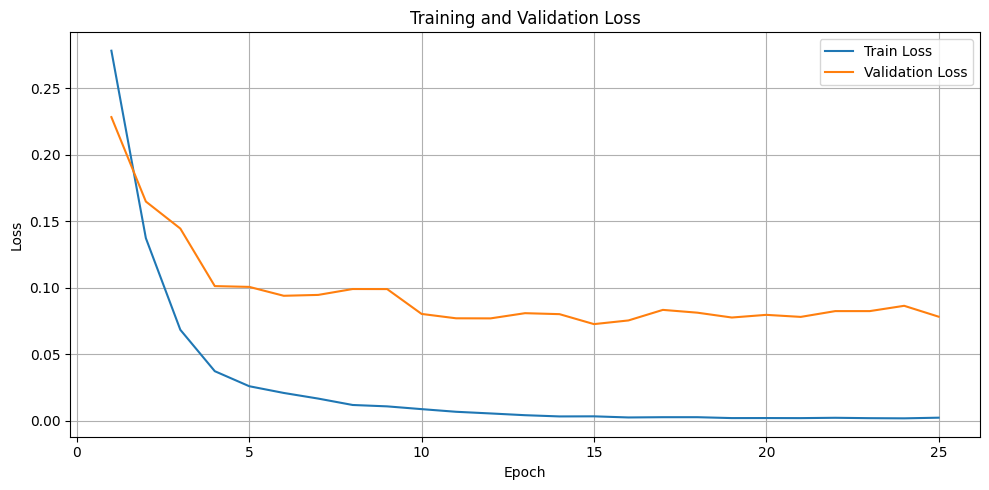

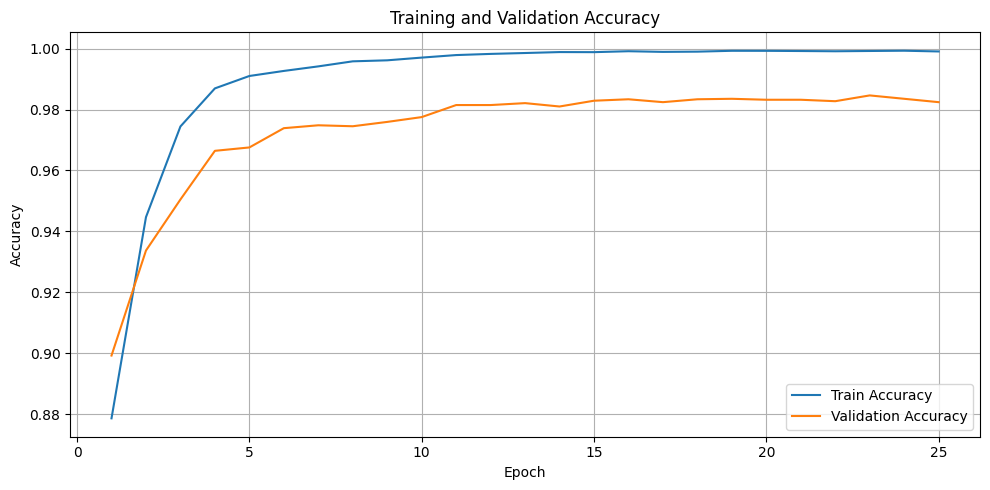

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import ImageFile
from sklearn.metrics import f1_score, multilabel_confusion_matrix
import numpy as np

# Assume that test_dataset and your model class SwinClassifier are already defined
BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

checkpoint_path = "best_Acne_swin_model.pth"
#checkpoint_path = "/content/drive/MyDrive/AI Project I/best_Acne_swin_model.pth"

model = SwinClassifier(num_classes=10)  # Create an instance of your model
# 파일에서 state_dict를 직접 로드합니다.
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)
model.eval()

# Define the loss function (if you want to compute test loss)
criterion = nn.BCEWithLogitsLoss()

# Run testing/inference
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Testing", leave=False)
with torch.no_grad():
    for images, labels in test_pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.float())

        batch_size = images.size(0)
        test_loss += loss.item() * batch_size
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += predicted.numel()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

avg_loss = test_loss / total if total > 0 else 0
accuracy = correct / total if total > 0 else 0

# Calculate F1 score and confusion matrix
f1 = f1_score(all_labels, all_preds, average='samples')  # or 'binary' for binary classification
conf_matrix_per_class = multilabel_confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print("Confusion Matrix per Class and Class Accuracy:")
for i, cm in enumerate(conf_matrix_per_class):
    tp = cm[1][1]  # True Positive
    fn = cm[1][0]  # False Negative
    fp = cm[0][1]  # False Positive
    tn = cm[0][0]  # True Negative

    # 정확도 계산: (TP + TN) / (TP + TN + FP + FN)
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # 클래스별 confusion matrix와 정확도 출력
    print(f"Class: {class_names[i]}")
    print(cm)
    print(f"Accuracy: {accuracy:.4f}")
    print()

Test Loss: 0.0046, Test Accuracy: 0.9912, F1 Score: 0.9868
Confusion Matrix per Class and Class Accuracy:
Class: Pimples
[[ 34   0]
 [  0 182]]
Accuracy: 1.0000

Class: blackhead
[[150   1]
 [  1  64]]
Accuracy: 0.9907

Class: conglobata
[[214   0]
 [  1   1]]
Accuracy: 0.9954

Class: crystanlline
[[199   0]
 [  5  12]]
Accuracy: 0.9769

Class: cystic
[[178   1]
 [  0  37]]
Accuracy: 0.9954

Class: folliculitis
[[197   0]
 [  3  16]]
Accuracy: 0.9861

Class: keloid
[[196   0]
 [  1  19]]
Accuracy: 0.9954

Class: milium
[[194   0]
 [  1  21]]
Accuracy: 0.9954

Class: papular
[[ 85   1]
 [  0 130]]
Accuracy: 0.9954

Class: purulent
[[ 95   2]
 [  2 117]]
Accuracy: 0.9815

